# Prédiction des instants de changement de percept dans un modèle de perception mutlistable

This code is intended to reproduce the results presented in the paper
submitted to the conference Gretsi 2025.




## Aknowlegement
This work was supported by NeuroCoG IDEX UGA, “Investissements d'avenir” program [grant number ANR-15-IDEX-02] and by the project VISION-3E [grant number ANR-21-CE37-0018]


## License

Copyright (c) 2025 Massyl Moudoud\
Author: Massyl Moudoud <mmoudoud@unistra.fr>\
Contributor : Ronald Phlypo <ronald.phlypo@grenoble-inp.fr>

This work was supported by NeuroCoG IDEX UGA, “Investissements d'avenir” program [grant number ANR-15-IDEX-02] and by the project VISION-3E [grant number ANR-21-CE37-0018]

This software is governed by the CeCILL  license under French law and
abiding by the rules of distribution of free software.  You can  use,
modify and/ or redistribute the software under the terms of the CeCILL
license as circulated by CEA, CNRS and INRIA at the following URL
"http://www.cecill.info".

As a counterpart to the access to the source code and  rights to copy,
modify and redistribute granted by the license, users are provided only
with a limited warranty  and the software's author,  the holder of the
economic rights,  and the successive licensors  have only  limited
liability.

In this respect, the user's attention is drawn to the risks associated
with loading,  using,  modifying and/or developing or reproducing the
software by the user in light of its specific status of free software,
that may mean  that it is complicated to manipulate,  and  that  also
therefore means  that it is reserved for developers  and  experienced
professionals having in-depth computer knowledge. Users are therefore
encouraged to load and test the software's suitability as regards their
requirements in conditions enabling the security of their systems and/or
data to be ensured and,  more generally, to use and operate it in the
same conditions as regards security.

The fact that you are presently reading this means that you have had
knowledge of the CeCILL license and that you accept its terms.

## Requirements
A python envrironment with:\
    Jupyter notebook\
    numpy\
    scipy\
    matplotlib\
    Latex installed #to format the figures

## Settings

In [1]:
from time import time
start_time_all = time()

In [2]:
# chose if you want to save the figures of just display them
save_plots = True

# Chose if you want to use latex to format the figures texts
use_latex = False


## Imports

In [3]:
# Imports
import matplotlib
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from time import time
#%matplotlib notebook

#Use the new random generator
rng = np.random.default_rng()

#make a shortcut for standard normal distribution
gauss = rng.standard_normal

In [4]:
if use_latex:
    plt.rcParams.update({'text.usetex' : True, 'font.family':"ptm"})

### Functions for plotting the results

In [5]:
def get_residence_times(change , percept):
    """
    Extract the dominance times of the percept from the time evolution
    of the dominant percept and the change of percept instants
    Inputs:
        change    : Binary array, true at the instant where change of percept happpened
        percept   : Array of the dominant percept in time
    Outputs:
        all_times : Array of the dominance durations of all the percepts
        C_times   : Array of the dominance durations of the Coherent (C) percept
        T_times   : Array of the dominance durations of the Transparent (T) percept 
    """
    T_times = []
    C_times = []

    change_idx = np.where(change)[0]
    Nb_change = len(change_idx)

    for i in range(Nb_change - 1): #discard last percept (stopped simulation)
        
        idx = change_idx[i]
        residence_time = change_idx[i+1] -change_idx[i]
        
        #if we change to C
        if percept[idx+1] == 1 :
            C_times.append(residence_time)
        #If we change to T
        else: #== 0
            T_times.append(residence_time)

    C_times = np.array(C_times)/1000 #convert from ms to second
    T_times = np.array(T_times)/1000

    all_times = np.concatenate((C_times , T_times))
    
    return (all_times , C_times , T_times)

In [6]:
def fit_distributions(all_times, C_times, T_times):
    """
    Fit Gamma and Log Normal distributions to the dominance times data
    Inputs:
        all_times : Array of the dominance durations of all the percepts
        C_times   : Array of the dominance durations of the Coherent (C) percept
        T_times   : Array of the dominance durations of the Transparent (T) percept
    Outputs:
        (gamma_hat_all , lognorm_hat_all ,gamma_hat_C , lognorm_hat_C , gamma_hat_T , lognorm_hat_T): 
                Fitted distributions for each familly and percept
    """
    
    gamma = sp.stats.gamma
    lognorm = sp.stats.lognorm
    
    
    ########################
    #All percepts
    #fit gamma
    a_hat , loc_hat , scale_hat = gamma.fit(all_times)
    gamma_hat_all  = gamma(a_hat , loc_hat , scale_hat)

    #fit log normal
    s_hat , loc_hat , scale_hat = lognorm.fit(all_times)
    lognorm_hat_all  = lognorm( s_hat , loc_hat , scale_hat)
    #########################
    
    
    ########################
    #Coherent (C) percepts
    #fit gamma
    a_hat , loc_hat , scale_hat = gamma.fit(C_times)
    gamma_hat_C  = gamma(a_hat , loc_hat , scale_hat)

    #fit log normal
    s_hat , loc_hat , scale_hat = lognorm.fit(C_times)
    lognorm_hat_C = lognorm( s_hat , loc_hat , scale_hat)
    #########################
    
    
    ########################
    #Transparent (T) percepts
    #fit gamma
    a_hat , loc_hat , scale_hat = gamma.fit(T_times)
    gamma_hat_T  = gamma(a_hat , loc_hat , scale_hat)

    #fit log normal
    s_hat , loc_hat , scale_hat = lognorm.fit(T_times)
    lognorm_hat_T = lognorm( s_hat , loc_hat , scale_hat)
    #########################
    
    
    return (gamma_hat_all , lognorm_hat_all ,gamma_hat_C , 
            lognorm_hat_C , gamma_hat_T , lognorm_hat_T)

In [7]:
def plot_hist_residence_times(all_times, C_times, T_times, Nbins = 150, spath = None):
    """
    Fit Gamma and Log Normal distributions to the dominance times histograms and plot them.
    Inputs:
        all_times : Array of the dominance durations of all the percepts
        C_times   : Array of the dominance durations of the Coherent (C) percept
        T_times   : Array of the dominance durations of the Transparent (T) percept 
        Nbins     : Nuùber of bins used to draw the histograms, default is 150
        spath     : Path to save the figure (None to disable saving)
    """
    #fit distributions
    gamma = sp.stats.gamma
    lognorm = sp.stats.lognorm
    max_x = np.ceil(np.percentile(all_times , 99))
    x = np.linspace(0, max_x , 500)
    
    plt.figure(layout='constrained' , figsize=(7,5))
    
    # Coh
    ax1 = plt.subplot(211)
    count, bins, ignored = plt.hist(C_times,Nbins,density=True, color = 'w', ec = 'k' , lw = 0.5) 
    plt.title(r"Cohérent $f_{\tau}(\tau | Percept=Coh)$")
    plt.ylabel("Densité de probabilité", fontsize=19, y = -0.22)
    
    # fit gamma
    a_hat , loc_hat , scale_hat = gamma.fit(C_times)
    gamma_hat  = gamma.pdf(x, a_hat , loc_hat , scale_hat)
    plt.plot(x , gamma_hat , color = "g", label = "Gamma")
    
    # fit log normal
    s_hat , loc_hat , scale_hat = lognorm.fit(C_times)
    lognorm_hat  = lognorm.pdf(x, s_hat , loc_hat , scale_hat)
    plt.plot(x , lognorm_hat , color = "k", label = "Log normal")
    
    # Tr
    plt.subplot(212, sharex=ax1, sharey=ax1)
    count, bins, ignored = plt.hist(T_times,Nbins,density=True, color = 'w', ec = 'k' , lw = 0.5) 
    plt.title(r"Transparent $f_{\tau}(\tau | Percept=Tr)$" )
    
    #fit gamma
    a_hat , loc_hat , scale_hat = gamma.fit(T_times)
    gamma_hat  = gamma.pdf(x, a_hat , loc_hat , scale_hat)
    plt.plot(x , gamma_hat , color = "g")
    
    # fit log normal
    s_hat , loc_hat , scale_hat = lognorm.fit(T_times)
    lognorm_hat  = lognorm.pdf(x, s_hat , loc_hat , scale_hat)
    plt.plot(x , lognorm_hat , color = "k")
    
    plt.xlabel(r"Temps de  dominance $\tau$ en secondes" , fontsize=19)
    plt.figlegend(loc=(0.638, 0.73) , fontsize=19) #'upper right'
    
    max_y = plt.ylim()[-1]
    plt.yticks(np.round(np.linspace(0, max_y, 3), 2));
    
    plt.xlim((0, np.max(x)+ 0.01))
    #save the figure
    if(spath != None):
        plt.savefig(spath)
    plt.show()

# 1. Méthodes

## 1.1 Modèle de la dynamique neuronal

__Paramètres de la simulation__

In [8]:
dt= 0.001 #sampling time (s) 
T = 4e4 # total time of the simulations (s)
N = int(T //dt) + 1 #Number of evaluated points
t = np.arange(0 , T , dt) #Time vector

__Génération des taux de déclenchement
d'entrée__

In [9]:
tau_s = 0.200 #s
sigma_s = 0.08

white_noise =  gauss((2, N)) 

Input_firing_rates = np.zeros((2, N))

alpha = ((tau_s - dt)/tau_s)
b = sigma_s * np.sqrt(2/tau_s) * np.sqrt(dt) 

for i in range(N-1):
    Input_firing_rates[:, i+1] = alpha * Input_firing_rates[:, i] + b*white_noise[:, i]

In [10]:
It0 = 0.95 #Input firing rates to the Transparent population 
Ic0 = 0.95 #Bias term for the input firing rates to the Coherent population

Ic_vals = Input_firing_rates[0, :]+ Ic0
It_vals = Input_firing_rates[1, :]+ It0

__Simulation du modèle__

Basé sur les équations de nHuguet et al. [5]

__Le Sigmoid S(x)__
$$ S(x) = \frac{1}{1+ \exp ^{\frac{x - \theta}{k}}}$$

In [11]:
def S(x, theta = 0.2 , k = 0.1):
    return 1 / (1 + np.exp(-(x-theta)/k))

__Simulation numérique__

In [12]:
#compute execution time
start_time = time()

#parameters for main process
tau = 0.010 #ms
beta = 1

#EOutput firing rate
Rc = np.zeros(N)
Rt = np.zeros(N)


#Adaptation
tau_a = 2.500 #s
rho = 0.15 #put to 0 for no adaptation

Ac = np.zeros(N)
At = np.zeros(N)

#Noise (not used in new model)
#tau_s = 0.200 #s
#sigma_s = 0.08 #0.08  #put to 0 for no noise
#Noise_c = np.zeros(N)
#Noise_t = np.zeros(N)
#gauss1 = gauss(N)
#gauss2 = gauss(N)

#save total input S(x)
Sc = np.zeros(N)
St = np.zeros(N)

#Save input to S(x)
InSc = np.zeros(N)
InSt = np.zeros(N)

#Current percept
change_thresh = 0.5 #difference threshold
diff_R = np.zeros(N) # difference between firing rates
percept = np.zeros(N) #current percept C : 1 , T : 0

#change instants
change = np.zeros(N)


for i in range(0 , N-1):
    #Coherent 
    InSc[i] = - beta * Rt[i] - Ac[i] + Ic_vals[i] # + Noise_c[i]
    Sc[i] = S(InSc[i])
    Rc[i+1] = ((tau -dt)/tau )* Rc[i] + Sc[i]*dt / tau
    #Transparent
    InSt[i] = - beta * Rc[i] - At[i] + It_vals[i] # + Noise_t[i]
    St[i] = S(InSt[i])
    Rt[i+1] = ((tau -dt)/tau)* Rt[i] + St[i]*dt/ tau
    
    #update the adaptation
    Ac[i+1] = ((tau_a - dt)/tau_a) * Ac[i] + (rho*dt / tau_a) * Rc[i]
    At[i+1] = ((tau_a - dt)/tau_a) * At[i] + (rho*dt / tau_a) * Rt[i]
    
    #Update Noise
    #Noise_c[i+1] = (1 - 1/tau_s)* Noise_c[i] + sigma_s * np.sqrt(2/tau_s) * np.sqrt(dt) * gauss1[i]
    #Noise_t[i+1] = (1 - 1/tau_s)* Noise_t[i] + sigma_s * np.sqrt(2/tau_s) * np.sqrt(dt) * gauss2[i]
    
    #Update current percept
    diff_R[i+1] = Rc[i+1] - Rt[i+1]
    #check if change happens
    if(diff_R[i+1] > 0.5 and percept[i] == 0):
        #Change to C
        percept[i+1] = 1
        #record change instants
        change[i+1] = 1
    elif(diff_R[i+1] < -0.5 and percept[i] == 1):
        #Change to T
        percept[i+1] = 0     
        #record change instants
        change[i+1] = 1
    else:
        #keep same percept
        percept[i+1] = percept[i]
   


print("Simulation lasted" , time() - start_time , "seconds")

Simulation lasted 156.50920176506042 seconds


__Save simulation__

In [13]:
#path = "./simulation_results/simulation_results.npz"
#np.savez_compressed(path, Ic_vals = Ic_vals, It_vals=It_vals , percept = percept, change = change)

# 2. Résultats et discussion

## 2.1  Ajuster les distributions aux données

__Figure 2 (a)__

In [14]:
#set font size
plt.rcParams.update({'font.size': 20})

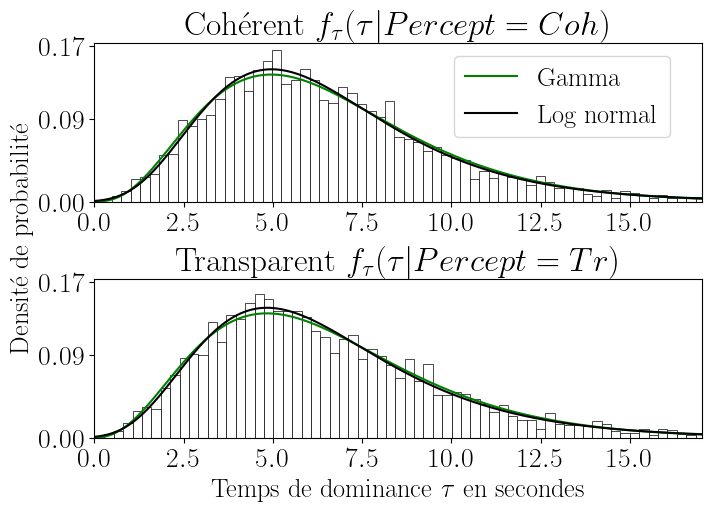

In [15]:
#get the residence times
all_times , C_times , T_times = get_residence_times(change , percept)

if save_plots:
    path = "./figures/Figure2a.pdf"
else:
    path = None
    
plot_hist_residence_times(all_times, C_times, T_times, Nbins = 100, spath = path)

In [16]:
#Compute some stats
print(f"There where {C_times.shape[0]} Coherent percepts")
print(f"There where {T_times.shape[0]} Transparent percepts")
print(f"The mean percept duration is {np.mean(all_times)} seconds")
print(f"The mean Coherent duration is {np.mean(C_times)} seconds")
print(f"The mean Transparent duration is {np.mean(T_times)} seconds")
print(f"The median percept duration is {np.median(all_times)} seconds")

There where 3077 Coherent percepts
There where 3077 Transparent percepts
The mean percept duration is 6.499076210594736 seconds
The mean Coherent duration is 6.511685082872927 seconds
The mean Transparent duration is 6.486467338316542 seconds
The median percept duration is 5.9405 seconds


In [17]:
(gamma_hat_all , lognorm_hat_all ,gamma_hat_C ,lognorm_hat_C , gamma_hat_T , lognorm_hat_T) = fit_distributions(all_times, C_times, T_times)

Get time in percept and time to change of percept from simulation data

In [18]:
change_idx = np.where(change)[0]

D_vals = np.zeros(N)
t_vals = np.zeros(N)

k = 0
for i in change_idx:
    t_vals[k:i] = np.arange(1 , i-k+1)
    D_vals[k:i] = np.arange(i-k , 0 , -1)
    k = i

#Convert to seconds
D_vals = D_vals/1000
t_vals = t_vals/1000

#get variable for ech percept separately
#Percept C
D_vals_C = D_vals[percept == 1]
t_vals_C = t_vals[percept == 1]

#percept T
D_vals_T = D_vals[percept == 0]
t_vals_T = t_vals[percept == 0]

__délais au changement de percept sachant le temps depuis le dernier changement__ $f(d|t, percept)$

__Figure 2 (b)__

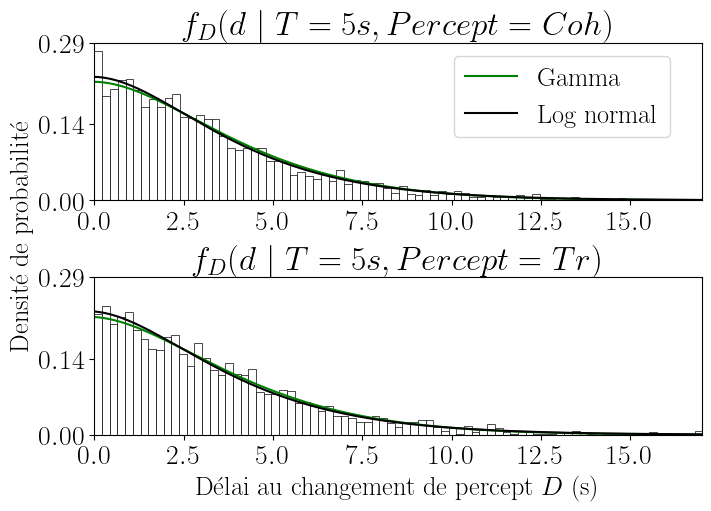

In [19]:
t0 = 5 #s
max_x = np.ceil(np.percentile(all_times , 99))
x = np.linspace(0, max_x , 500)
plt.figure(layout='constrained' , figsize=(7,5))
# ax1 = plt.subplot(311)
#all times
# plt.hist(D_vals[t_vals == t0] ,100,density=True, color = 'w', ec = 'k' , lw = 0.5);
#gamma
# plt.plot(x , gamma_hat_all.pdf(x+t0)/(1 - gamma_hat_all.cdf(t0)) , color = "g" , label = "Gamma")
#Lognorm
# plt.plot(x , lognorm_hat_all.pdf(x+t0)/(1 - lognorm_hat_all.cdf(t0)) , color = "k" , label = "Log normal")

# plt.title(r"All percepts $f_D (d~|~ T = 5s)$")

ax1 = plt.subplot(211)
#Percept C
plt.hist(D_vals_C[t_vals_C == t0] ,100,density=True , color = 'w', ec = 'k' , lw = 0.5);
#gamma
plt.plot(x , gamma_hat_C.pdf(x+t0)/(1 - gamma_hat_C.cdf(t0)) , color = "g", label = "Gamma")
#Lognorm
plt.plot(x , lognorm_hat_C.pdf(x+t0)/(1 - lognorm_hat_C.cdf(t0)) , color = "k", label = "Log normal")

plt.ylabel("Densité de probabilité", fontsize=19, y = -0.22)

plt.title(r"$f_D (d~|~T = 5s , Percept = Coh)$")

plt.subplot(212 , sharex = ax1 , sharey = ax1)
#Percept T
plt.hist(D_vals_T[t_vals_T == t0] ,100,density=True, color = 'w', ec = 'k' , lw = 0.5);
#gamma
plt.plot(x , gamma_hat_T.pdf(x+t0)/(1 - gamma_hat_T.cdf(t0)) , color = "g")
#Lognorm
plt.plot(x , lognorm_hat_T.pdf(x+t0)/(1 - lognorm_hat_T.cdf(t0)) , color = "k")
plt.xlabel(r"Délai au changement de percept $D$ (s)"  , fontsize=19)

plt.title(r"$f_D (d~|~T = 5s , Percept = Tr)$" ) #Percept Transparent


plt.figlegend(loc=(0.638, 0.73) , fontsize=19)
plt.xlim((0 , max_x))
#plt.suptitle("Distribution of time to change at time t = {}s since last change ".format(t0));
max_y = plt.ylim()[-1]
plt.yticks(np.round(np.linspace(0, max_y, 3), 2));

path = "./figures/Figure2b.pdf"

if save_plots:
    plt.savefig(path)

## 2.2 Estimation de $f(\Delta I | d , t , \mathrm{p})$

In [20]:
I_diff = Ic_vals - It_vals

In [21]:
#get the values of Ic near changes
change_idx = np.where(change)[0]
change_idx_C = np.where(np.logical_and(change, percept == 1 ))[0]
change_idx_T = np.where(np.logical_and(change, percept == 0 ))[0]


Nb_change_C = len(change_idx_C) -1
Nb_change_T = len(change_idx_T) -1


before_range = 500
after_range = 0
limit = (max(before_range , after_range)+10)

I_diff_idx_C = -np.ones_like(I_diff) * limit #int(np.min(all_times)*1000)

I_diff_idx_T = -np.ones_like(I_diff) * limit #int(np.min(all_times)*1000)


for i in range(0, before_range ):
    I_diff_idx_C[change_idx_C[1:-1] - i ] =   i 
    I_diff_idx_T[change_idx_T[1:-1] - i ] =   i 

__Figure 3 (a)__

In [22]:
plt.rcParams.update({'font.size': 20})

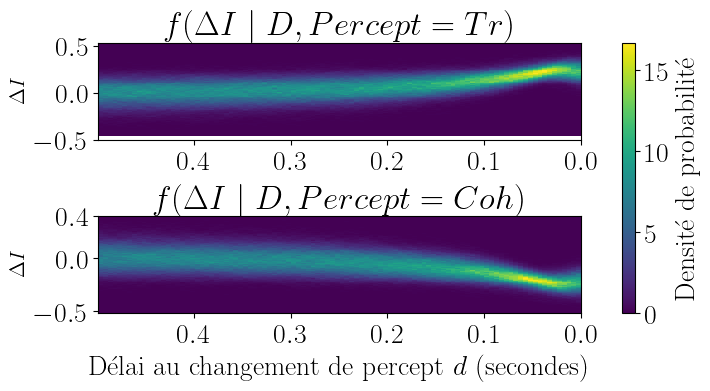

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1 , layout='constrained' , figsize =(7,3.8))
ax0 = axes[0]
ax1 = axes[1]

ax0.hist2d(I_diff_idx_C[np.where(I_diff_idx_C != - limit)]/1000, I_diff[np.where(I_diff_idx_C != - limit)] ,  bins = [100 , 100], density=True , edgecolors = None)# , norm ="log");
ax0.set_ylabel(r"$\Delta I$" ,  fontsize=15)
ax0.set_title(r"$f(\Delta I ~|~ D , Percept = Tr)$")
ax0.grid(False)


# set yticks
ymin, ymax = ax0.get_ylim()
ax0.set_yticks(np.round([ymin, 0, ymax], 1));

#ax0.add_patch(plt.Rectangle((-0.1, ymin) , 0.1 , ymax-ymin , fc = "none" , ec = 'c', lw = 2) )
ax1.sharex(ax0)
#ax1.sharey(ax0)
im = ax1.hist2d(I_diff_idx_T[np.where(I_diff_idx_T != - limit)]/1000, I_diff[np.where(I_diff_idx_T != - limit)] ,  bins = [100 , 100] , density=True)#, norm ="log");
ax1.set_ylabel(r"$\Delta I$" , fontsize=15)#I_{Coh} - I_{Tr}
ax1.set_xlabel(r"Délai au changement de percept $d$ (secondes)");
ax1.set_title(r"$f(\Delta I ~|~ D , Percept = Coh)$")
ax1.grid(False)

# set yticks
ymin, ymax = ax1.get_ylim()
ax1.set_yticks(np.round([ymin, 0, ymax], 1));
#ax1.add_patch(plt.Rectangle((-0.1, ymin) , 0.1 , ymax-ymin , fc = "none" , ec = 'c', lw = 2) )
#ax1.vlines([-0.1 , 0] , 0.4 , 1.4)


im =im[-1]
fig.colorbar(im, ax=axes.tolist() , label='Densité de probabilité');

ax1.invert_xaxis()
path = "./figures/Figure3.png"

if save_plots:
    plt.savefig(path)

__Moyenne et écart type de la différence des taux de déclenchement d'entrée conditionnée sur le délai au changement de percept__

In [24]:
max_delay = 1000 #Maximum delayfrom change (ms)
delays = np.arange(-max_delay , max_delay)
I_vals_C = np.zeros( (len(delays) , Nb_change_C ))
I_vals_T = np.zeros( (len(delays)  , Nb_change_T ))

for i , d in enumerate(delays):
    I_vals_C[i , :] = I_diff[change_idx_C[:-1] - d]
    I_vals_T[i , :] = I_diff[change_idx_T[:-1] - d]
    
I_diff_means_C = np.mean(I_vals_C , axis =1)
I_diff_std_C = np.std(I_vals_C , axis =1)
I_diff_means_T = np.mean(I_vals_T , axis =1)
I_diff_std_T = np.std(I_vals_T, axis =1)

I_diff_std = (I_diff_std_C + I_diff_std_T)/2


#Get the values of input firing rate far from the change of percept (>100ms before the change)
idx_far_C = np.logical_and(D_vals>0.100 , percept==1) 
idx_far_T = np.logical_and(D_vals>0.100 , percept==0) 

### Modèle de  $f(\Delta I | d , t , \mathrm{p})$

La distribution conditionnelle de~$\Delta I$ est proche d'une loi normale (théorème central limite).
	Nous proposons donc de modéliser $f(\Delta I | d , t , \mathrm{p})$ 
    par une variable aléatoire normale dont la moyenne et l'écart type dépendent du délai au changement de percept $d$.
	Une courbe gaussienne est utilisée pour modéliser la moyenne et l’écart type conditionnels en raison de leur forme en cloche:
	\begin{equation}
		\begin{aligned}
			&f(\Delta I | d , t , \mathrm{p}) = \mathcal{N} \left( \mu_{\Delta I}(d , \mathrm{p}), \sigma_{\Delta I}(d,\mathrm{p}) \right)\\
			&\mu_{\Delta I}(d), \sigma_{\Delta I}(d,\mathrm{p}) = A e^{-  \left(\frac{d -m}{v} \right)^2} + C  \, .
		\end{aligned}
	\end{equation}

In [25]:
def gauss_fit(x, A , m , v, c):
    """
    Generic function to model the mean and variance of the input firing rate by a gaussian
    """
    return A*np.exp(-((x-m)/v)**2) + c

__Fit mean in percept coherent__ $\mu_{\Delta I|percept = Coh}(d)$

In [26]:
#data to fit
max_d = delays.shape[0]
min_d = 0
x = delays[min_d :max_d]/1000
y = I_diff_means_C[min_d :max_d]

m_guess = x[np.argmax(I_diff_means_C)] #seconds
v_guess = 0.1 #seconds
c = np.mean(I_diff[idx_far_C]) #mean far from change
a_guess = np.max(y) - c

popt, pcov = sp.optimize.curve_fit(lambda x, A, m , v: gauss_fit(x ,A , m , v, c) , x, y,p0=(a_guess, m_guess , v_guess))

#Create the fitted function
def mu_C(x , A = popt[0] , m = popt[1] ,v = popt[2] , c = c):
    return gauss_fit(x, A , m , v, c)

__Fit mean in percept transparent__ $\mu_{\Delta I|percept = Tr}(d)$

In [27]:
#data to fit
max_d = delays.shape[0]
min_d = 0
x = delays[min_d :max_d]/1000
y = I_diff_means_T[min_d :max_d]

m_guess = x[np.argmin(y)] #seconds
v_guess = 0.01 #seconds
c = np.mean(I_diff[idx_far_T]) #mean far from change
a_guess =-0.5#np.min(y) - c

popt, pcov = sp.optimize.curve_fit(lambda x, A, m , v: gauss_fit(x ,A , m , v, c) , x, y,p0=(a_guess, m_guess , v_guess))

#Create the fitted function
def mu_T(x , A = popt[0] , m = popt[1] ,v = popt[2] , c = c):
    return gauss_fit(x, A , m , v, c)

__Fit standard deviation in all percepts__ $\sigma_{\Delta I} (d)$

In [28]:
#data to fit
max_d = delays.shape[0]
min_d = 0
x = delays[min_d :max_d]/1000
y = I_diff_std[min_d :max_d]

m_guess = x[np.argmin(y)] #seconds
v_guess = 0.1 #seconds
c = 0.1 #initial std (far from change)
a_guess = np.min(y) - c

popt, pcov = sp.optimize.curve_fit(lambda x, A, m , v: gauss_fit(x ,A , m , v, c) , x, y,p0=(a_guess, m_guess , v_guess))

#Create the fitted function
def sigma_I(x , A = popt[0] , m = popt[1] ,v = popt[2] , c = c):
    return gauss_fit(x, A , m , v, c)

__Figure 3 (b)__

In [29]:
#set font size
plt.rcParams.update({'font.size': 20})

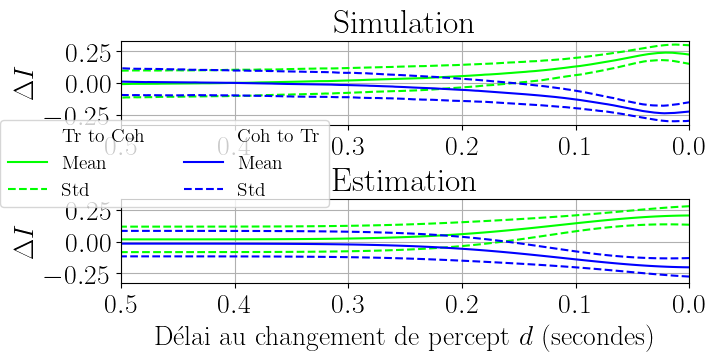

In [30]:
plt.figure(layout='constrained' , figsize=(7, 3.5))
ax1 =plt.subplot(211)
plt_mean_C, = plt.plot(delays/1000 , I_diff_means_C , color = "lime" , label = "Mean change to C")
plt_std_C, = plt.plot(delays/1000 , I_diff_means_C + I_diff_std_C , color = "lime" , linestyle='--', label = "std")
plt.plot(delays/1000 , I_diff_means_C - I_diff_std_C , color = "lime" , linestyle='--')

plt_mean_T, = plt.plot(delays/1000 , I_diff_means_T , color = "b" , label = "Mean change to T")
plt_std_T,  = plt.plot(delays/1000 , I_diff_means_T + I_diff_std_T , "b--" )
plt.plot(delays/1000 , I_diff_means_T - I_diff_std_T , "b--")

p5, = plt.plot([], marker='None' , linestyle='None', label='dummy-tophead')

plt.grid()



plt.ylabel(r"$\Delta I$")
plt.figlegend([p5, plt_mean_C, plt_std_C, p5, plt_mean_T, plt_std_T],
              [r"Tr to Coh" , "Mean" , "Std" , "Coh to Tr", "Mean" , "Std"],
               ncol=2 , loc = (0, 0.425)  , fontsize=14) 


plt.title("Simulation")

plt.subplot(212 , sharex=ax1 , sharey=ax1)

D_test = np.linspace(0 , 0.5 , 100)

plt_mean_C, = plt.plot(D_test , mu_C(D_test) , color = "lime" , label = "Mean change to C")
plt_std_C, = plt.plot(D_test, mu_C(D_test) + sigma_I(D_test) , color = "lime" , linestyle='--', label = "std")
plt.plot(D_test , mu_C(D_test) - sigma_I(D_test) , color = "lime" , linestyle='--')

plt_mean_T, = plt.plot(D_test , mu_T(D_test) , color = "b" , label = "Mean change to T")
plt_std_T,  = plt.plot(D_test , mu_T(D_test) + sigma_I(D_test) , "b--" )
plt.plot(D_test , mu_T(D_test)- sigma_I(D_test) , "b--")

p5, = plt.plot([], marker='None' , linestyle='None', label='dummy-tophead')

plt.grid()

plt.xlim([0, 0.5])
plt.xlabel("Délai au changement de percept $d$ (secondes)" )
plt.ylabel(r"$\Delta I$" )

plt.title(" Estimation")

ax1.invert_xaxis()

path = "./figures/Figure3b.pdf"

if save_plots:
    plt.savefig(path)

__Génération de__ $f(\Delta I | d , t , \mathrm{p})$

In [31]:
def normal_dist(x, mu , sigma):
    return np.exp(-(x-mu)**2 / (2*sigma**2))/(sigma*np.sqrt(2*np.pi))

def f_I_D_P(I_diff, d, percept, mu_C, mu_T, sigma_I):
    """
    Return F_ic(ic|D , percept)
    Inputs:
        mu_C , mu_T: function that returns the mean of $Delta I$ given D and percept (C or T)
                        E(Delta I|D, percept)
        sigma_I: function that returns the stdandard deviation of $Delta I$ given D Sigma(Delta I|D)
    """
    if percept==1: #percept coherent
        return normal_dist(I_diff, mu_C(d) , sigma_I(d))
    else: #percept transparent
        return normal_dist(I_diff , mu_T(d) , sigma_I(d))
    

__Figure supplémentaire non incluse dans le papier__

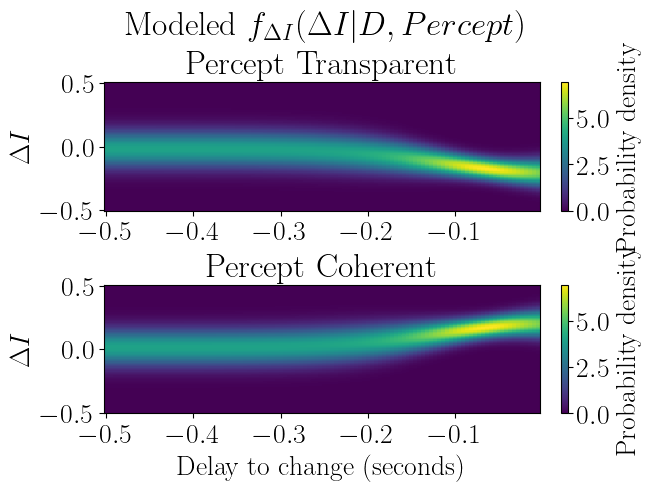

In [32]:
I_diff_test = np.linspace(-0.5 , 0.5 , 100)#np.linspace(0.55 , 1.3 , 100)
D_test = np.linspace(0.005 , 0.5 , 110)

D_test , I_diff_test = np.meshgrid( D_test , I_diff_test)

prob_C = f_I_D_P(I_diff_test , D_test ,  1 , mu_C, mu_T, sigma_I)
prob_T = f_I_D_P(I_diff_test , D_test ,  0 , mu_C, mu_T, sigma_I)

plt.figure(layout='constrained')
plt.subplot(211)
#plt.imshow(prob_T.T)
plt.pcolor( -D_test , I_diff_test , prob_T)
plt.colorbar(label= "Probability density")
plt.ylabel("$\Delta I$")
plt.title("Percept Transparent ")
plt.subplot(212)
#plt.imshow(prob_C.T)
plt.pcolor(- D_test , I_diff_test , prob_C)
plt.colorbar(label= "Probability density")
plt.ylabel("$\Delta I$")
plt.title("Percept Coherent")
plt.xlabel("Delay to change (seconds)")

plt.suptitle(r"Modeled $f_{\Delta I}(\Delta I|D , Percept)$")

path = "./figures/Additional_figure"

if save_plots:
    plt.savefig(path)

## 2.3. La distribution a posteriori de $D$

In [33]:
#Percept C
D_vals_C = D_vals[percept == 1]
t_vals_C = t_vals[percept == 1]

#percept T
D_vals_T = D_vals[percept == 0]
t_vals_T = t_vals[percept == 0]

In [34]:
def get_f_D_T_P(dist_C , dist_T):
    def pdf_cond_p(d, t, percept):
        if percept == 1: #coherent percept
            return dist_C.pdf(d+t)/(1 - dist_C.cdf(t))
        else : 
            return dist_T.pdf(d+t)/(1 - dist_T.cdf(t))
                                    
    return pdf_cond_p                 
    
#f_D_T_P(d| t , percept)
f_D_T_P = get_f_D_T_P(gamma_hat_C , gamma_hat_T)

In [35]:
#based on integral
def f_I_T_P(I_diff ,t ,percept , N_D = 1000 , d_inf = 50):
    """
    f_I(I_diff|t , percept) = intergal(f_I(I_diff , d|t, percept) over d)
    Inputs:
        t  : Time since last change of percept (seconds)
        I0: over all (uncoditional) mean of I_diff (bias term in the simulation)
        stdev: over all (uncoditional) standard deviation of Ic
        N_D: Number of points in numerical integration
        d_inf: limit of integration
    """
    delta_d = d_inf/N_D
    a = 0.0 #starting point of integration

    
    #Use direct sum
    D_test = np.arange(a , d_inf , delta_d)
        
    #full equation
    return np.trapz(f_I_D_P(I_diff, D_test, percept, mu_C, mu_T, sigma_I)*f_D_T_P(D_test , t= t , percept = percept), x=D_test, axis=0)

In [36]:
def f_D_I_T_P(d, I_diff , t , percept):
        
    cst = f_I_T_P(I_diff , t ,percept)
    
    return (f_I_D_P(I_diff, d, percept, mu_C, mu_T, sigma_I)*f_D_T_P(d ,t , percept)) / cst

### The probability $P(D  <  d_0 | \Delta I,   t  , \mathrm{p})$

In [37]:
def Pr_D_I_T_P(d0, N_D , I_diff, t , percept ):
    delta_d = d0/N_D
    a = 0 #starting point of integration
    
    #Use direct sum
    D_test = np.arange(a , d0 , delta_d)
    return np.trapz(f_D_I_T_P(D_test,I_diff , t , percept), x = D_test)
    

In [38]:
def Pr_D_T_P(d0, N_D , I_diff, t , percept):
    
    if percept == 1: #percept C
        return (gamma_hat_C.cdf(t + d0) - gamma_hat_C.cdf(t))/(1 - gamma_hat_C.cdf(t))
    else: #percept T
        return (gamma_hat_T.cdf(t + d0) - gamma_hat_T.cdf(t))/(1 - gamma_hat_T.cdf(t))


In [39]:
N_T = 110
N_I= 100
T_test = np.linspace(0, 10, N_T)
I_test = np.linspace(-0.5 , 0.5 , N_I)
d0 = 0.5 #s
N_D = 1000 #points for numerical intergration

prob_C = np.zeros((N_I , N_T))
prob_T = np.zeros((N_I , N_T))

for i , I_ in enumerate(I_test):
    for j , t_ in enumerate(T_test):
        prob_C[i , j] = Pr_D_I_T_P(d0, N_D , I_, t_ , 1 )  
        prob_T[i , j] = Pr_D_I_T_P(d0, N_D , I_, t_ , 0 )


__Figure 4__

In [40]:
#set font size
plt.rcParams.update({'font.size': 16})

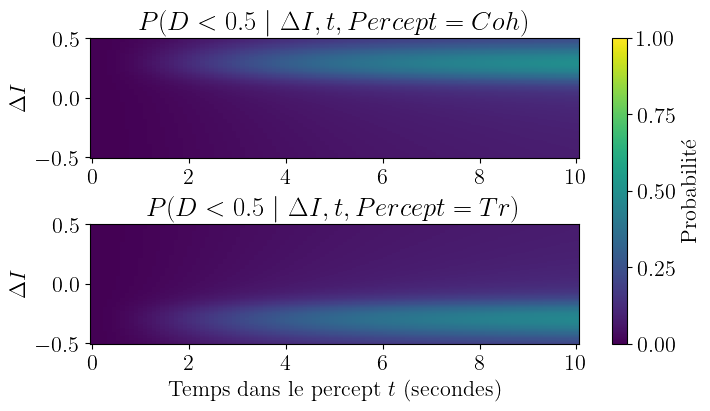

In [41]:
plt.figure(layout ='constrained' , figsize=(7, 4))
ax1 = plt.subplot(211)
plt.pcolor( T_test , I_test , prob_C , vmin =0 , vmax =1)
plt.ylabel(r"$\Delta I$")
plt.title(rf"$P(D < {d0} ~|~ \Delta I, t , Percept = Coh)$")
ax2 = plt.subplot(212 , sharex = ax1, sharey =ax1)
plt.pcolor( T_test , I_test , prob_T , vmin =0 , vmax =1)
plt.colorbar(ax = (ax1, ax2), label= "Probabilité" , ticks =[0, 0.25, 0.5, 0.75 , 1])
plt.ylabel(r"$\Delta I$")
plt.title(rf"$P(D < {d0} ~|~ \Delta I, t , Percept = Tr)$" )
plt.xlabel(r"Temps dans le percept $t$ (secondes)")

path = "./figures/Figure4.png"

if save_plots:
    plt.savefig(path)

# Prediction of probability of change in short simulation

### Run short simulation

In [42]:
#parameters of simulation
dt= 0.001 #sampling time (s) 
T = 50 # total time of the simulations (s)
N = int(T //dt) + 1 #Number of evaluated points
t = np.arange(0 , T , dt) #Time vector

In [43]:
#input firing rate with noise of the model of Huguet

tau_s = 0.200 #s
sigma_s = 0.08

white_noise =  gauss((2, N)) 

Input_firing_rates = np.zeros((2, N))

alpha = ((tau_s - dt)/tau_s)
b = sigma_s * np.sqrt(2/tau_s) * np.sqrt(dt) 

for i in range(N-1):
    Input_firing_rates[:, i+1] = alpha * Input_firing_rates[:, i] + b*white_noise[:, i]
    
It0 = 0.95 #Input firing rates to the Transparent population 
Ic0 = 0.95 #Bias term for the input firing rates to the Coherent population

Ic_vals = Input_firing_rates[0, :]+ Ic0
It_vals = Input_firing_rates[1, :]+ It0

In [44]:
#The simulation

#parameters for main process
tau = 0.010 #ms
beta = 1

#Output firing rate
Rc = np.zeros(N)
Rt = np.zeros(N)


#Adaptation
tau_a = 2.500 #s
rho = 0.15 #put to 0 for no adaptation

Ac = np.zeros(N)
At = np.zeros(N)

#Noise (not used in new model)
tau_s = 0.200 #s
sigma_s = 0.08 #0.08  #put to 0 for no noise
#Noise_c = np.zeros(N)
#Noise_t = np.zeros(N)
#gauss1 = gauss(N)
#gauss2 = gauss(N)

#save total input S(x)
Sc = np.zeros(N)
St = np.zeros(N)

#Save input to S(x)
InSc = np.zeros(N)
InSt = np.zeros(N)

#Current percept
change_thresh = 0.5 #difference threshold
diff_R = np.zeros(N) # difference between firing rates
percept = np.zeros(N) #current percept C : 1 , T : 0

#change instants
change = np.zeros(N)


for i in range(0 , N-1):
    #Coherent 
    InSc[i] = - beta * Rt[i] - Ac[i] + Ic_vals[i] # + Noise_c[i]
    Sc[i] = S(InSc[i])
    Rc[i+1] = ((tau -dt)/tau )* Rc[i] + Sc[i]*dt / tau
    #Transparent
    InSt[i] = - beta * Rc[i] - At[i] + It_vals[i] # + Noise_t[i]
    St[i] = S(InSt[i])
    Rt[i+1] = ((tau -dt)/tau)* Rt[i] + St[i]*dt/ tau
    
    #update the adaptation
    Ac[i+1] = ((tau_a - dt)/tau_a) * Ac[i] + (rho*dt / tau_a) * Rc[i]
    At[i+1] = ((tau_a - dt)/tau_a) * At[i] + (rho*dt / tau_a) * Rt[i]
    
    #Update Noise
    #Noise_c[i+1] = (1 - 1/tau_s)* Noise_c[i] + sigma_s * np.sqrt(2/tau_s) * np.sqrt(dt) * gauss1[i]
    #Noise_t[i+1] = (1 - 1/tau_s)* Noise_t[i] + sigma_s * np.sqrt(2/tau_s) * np.sqrt(dt) * gauss2[i]
    
    #Update current percept
    diff_R[i+1] = Rc[i+1] - Rt[i+1]
    #check if change happens
    if(diff_R[i+1] > 0.5 and percept[i] == 0):
        #Change to C
        percept[i+1] = 1
        #record change instants
        change[i+1] = 1
    elif(diff_R[i+1] < -0.5 and percept[i] == 1):
        #Change to T
        percept[i+1] = 0     
        #record change instants
        change[i+1] = 1
    else:
        #keep same percept
        percept[i+1] = percept[i]

### Extraxt the probabilities of change

In [45]:
def get_prob_change(prob , percept, I_vals,t_vals, d0):
    prob_change = np.zeros_like(I_vals)
    N_D = 500
    for i, (I_diff, t, p) in enumerate(zip(I_vals, t_vals, percept)):
        prob_change[i] = prob(d0, N_D , I_diff, t , p )
    
    
    return prob_change

In [46]:
I_diff = Ic_vals - It_vals

In [47]:
#Get delays to change
#using the change instants

change_idx = np.where(change)[0]

D_vals = np.zeros(N)
t_vals = np.zeros(N)

k = 0
for i in change_idx:
    t_vals[k:i] = np.arange(1 , i-k+1)
    D_vals[k:i] = np.arange(i-k , 0 , -1)
    k = i
#last percept (no change due to end of experiment)
k = change_idx[-1]
t_vals[k:] = np.arange(1 , N-k+1)
D_vals[k:] = np.arange(N-k , 0 , -1)

D_vals = D_vals/1000
t_vals = t_vals/1000

In [48]:
# pdf aposteriory
# Evaluate pdf not for instants to win speed  
evaluation_rate = 10 

D_inf = 15
N_D = 100

D_test  = np.linspace(0, D_inf, N_D)
proba_D = np.zeros((N_D, N//evaluation_rate))

for i, (Id_, t_, p_) in enumerate(zip(I_diff, t_vals, percept)):
    if i%evaluation_rate ==0:
        proba_D[:, i//evaluation_rate] = f_D_I_T_P(D_test,Id_ , t_ , p_)

# Plot prediction short

In [49]:
def plot_prediction_Gretsi(t,
                           Rc,
                           Rt,
                           Ac,
                           At,
                           Ic_vals, 
                           It_vals,
                           percept,
                           change_idx,
                           D_vals,
                           proba_D,
                           spath = None):
    
    """
    Plots the evolution of the simulation states and output variables 
    In addition with the predicted probability of change of percept in a given time window.
    Inputs:
        t           : Time vector 
        Ac , At     : Value of the firing rate adaptation of the populations C and T
        Rc , Rt     : Values of the output firing ratesof populations C and T
        Ic_vals,    : Values of input firing rates to the populations C and T
        It_vals
        percept     : Value of the current percept (encoded as C:1 , T:0)
        change_idx  : Idices of the changes of percept
        D_vals      : Values at which the pdf of D is evaluated
        proba_D      : Conditional PDF of D gievn Delta_I, time in percept f(D | Delta I, t, pecept)
        spath       : Path to save the figure (None to disable saving)   
    """
    fig, [ax1, ax2, ax3, ax4, ax5] =  plt.subplots(5, 1,
                                                  figsize = (7, 6),
                                                  layout  = 'constrained',
                                                  sharex  = True,
                                                  height_ratios = [1.5, 1.5, 1, 1.5, 3])# [1.75, 1.75, 1.75, 1.75, 3]
    
    ###############################################################
    
    ax1.plot(t , Ac , color = "lime")
    ax1.plot(t , At , color = 'b')
    ax1.set_title(r"Adaptation $\mathrm{A_i}$")
    
    ###############################################################
    ax2.plot(t , Rc , color = "lime" , label = "Coh")
    ax2.plot(t, Rt , color = 'b' , label = "Tr")
    ax2.set_title(r"Taux de déclenchement $\mathrm{R_i}$")
    
    ###############################################################
    color =['b' , 'lime'] #for Tr and Coh
    fill_list = list()
    idx = change_idx[0]
    y =[0 , 1 , 1, 0]
    fill_list.append([0 ,0 ,t[idx] , t[idx]] )
    fill_list.append(y)
    fill_list.append(color[int(percept[2])])
    for i in range(len(change_idx) -1):
        idx = change_idx[i]
        x = [t[idx] , t[idx] , t[change_idx[i+1]] , t[change_idx[i+1]]]  
        fill_list.append(x)
        fill_list.append(y)
        fill_list.append(color[int(percept[idx+1])])
    #last percept
    idx = change_idx[-1]
    fill_list.append([t[idx] , t[idx], t[-1] , t[-1]] )
    fill_list.append(y)
    fill_list.append(color[int(percept[-1])])
    ax3.fill(*fill_list);
    ax3.set_yticks([])
    ax3.set_ylim([0,1])
    ax3.set_title("Percept actif")
    
    ###############################################################
    ax4.plot(t , Ic_vals - It_vals ,color = "k")
    ax4.set_ylim((-0.5, 0.5))
    ax4.set_title("Diff des taux de déclenchement d’entrée $\Delta I$")
    ax4.set_ylabel(r"$\Delta I$")
    
    ###############################################################    
    fct = len(t)// proba_D.shape[1]
    t_ = t[np.arange(len(t))%fct == 0]
    
    im = ax5.pcolormesh( t_ ,D_vals, proba_D  , vmin =0, vmax =0.2, shading="gouraud")
    ax5.set_yticks([0, 7 , 15])
    ax5.set_title(r"$f_D(d~|~\Delta I, t, percept)$")
    ax5.set_ylabel("Délai $D$")
    plt.colorbar(im, label ="Densité" , aspect= 12)

    
    ###############################################################
    ax5.set_xlim([0, np.round(np.max(t))])
    ax5.set_xlabel("Temps (s)")
    plt.figlegend(loc=(0.81, 0.77))
    
    #save the figure
    if(spath != None):
        plt.savefig(spath)


__Figure 5__

In [50]:
plt.rcParams['path.simplify'] = True

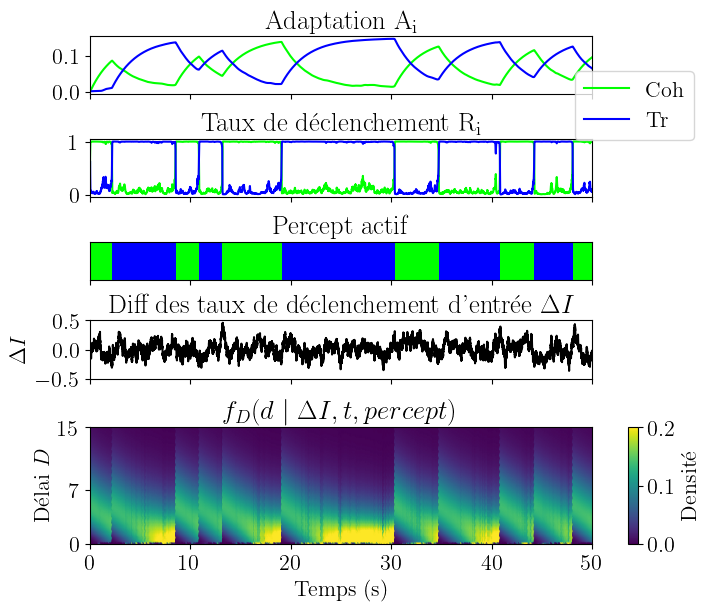

In [51]:
if save_plots:
    path = "./figures/Figure5.jpeg"
else:
    path = None
plot_prediction_Gretsi(t , Rc , Rt , Ac , At , Ic_vals , It_vals, percept, change_idx ,  D_test, proba_D , spath  = path )

In [52]:
print("Simulation lasted" , time() - start_time_all , "seconds")

Simulation lasted 280.0754232406616 seconds
